<a href="https://colab.research.google.com/github/yerimming/gachon/blob/main/RandAugment%2Baugmentation_%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

from torch.utils.data import ConcatDataset

from adamp import AdamP

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [ ]:
### Custom Dataset ###
# Create DataLoader
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.mode = mode
    self.transform = transform

    if self.mode == 'train':
      self.image_folder = os.listdir('/home/ubuntu/CV_G/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/home/ubuntu/CV_G/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/home/ubuntu/CV_G/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/home/ubuntu/CV_G/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)

    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


In [ ]:
from torchvision.transforms import RandAugment

### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([transforms.Resize((448, 448)),transforms.ToTensor(),])
transforms_test = transforms.Compose([transforms.Resize((448,448)),transforms.ToTensor(),])
transforms_train_aug = transforms.Compose([
    transforms.Resize((448, 448)),
    RandAugment(5,3),  # Apply RandAugment
    transforms.ToTensor(),
])
transforms_train_g_v=transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
])

BATCH_SIZE = 32
train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
train_set_augmented = CUB2011(mode='train', transform=transforms_train_aug)
train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v)

# 3 데이터셋을 연결하여 새로운 훈련 데이터셋 생성
train_set_combined = ConcatDataset([train_set_origin, train_set_augmented, train_set_augmented2])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")


Num of each dataset:  7080 296 298
Loaded dataloader


Batch 1


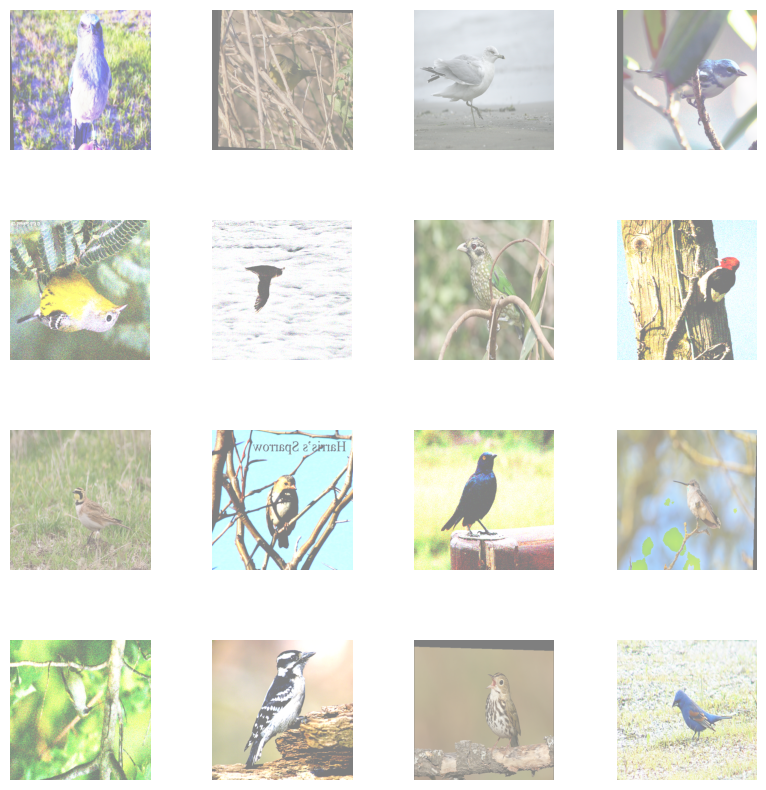

Batch 2


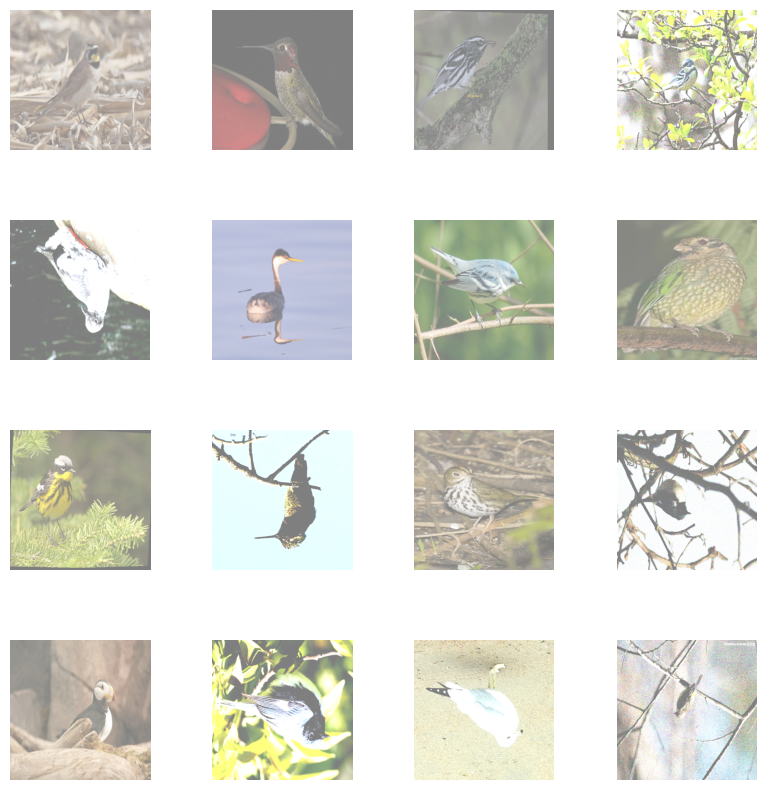

Batch 3


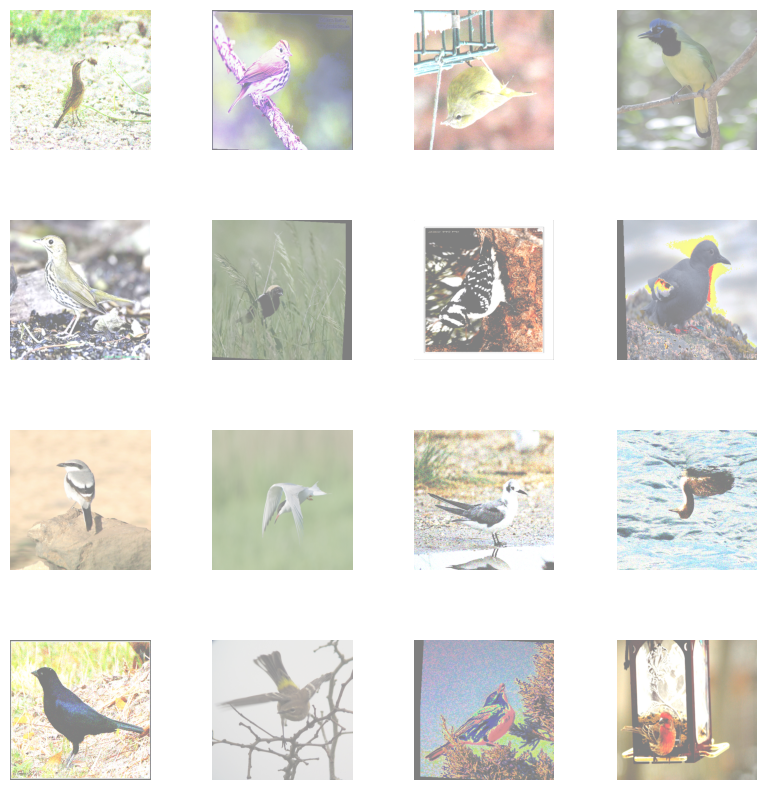

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of rows and columns for the grid
num_rows = 4  # You can change this to the desired number of rows
num_cols = 4  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index] / 2 + 0.5  # Unnormalize the image
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 3:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images


In [ ]:
from adamp import AdamP
### Model / Optimizer ###
EPOCH = 30
lr = 0.0001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
model.to(DEVICE)

optimizer = AdamP(model.parameters(),lr=lr,betas=(0.9, 0.999), weight_decay=1e-2)

print("Created a learning model and optimizer")

### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  # 모델을 학습 모드로 변환
  model.train()

  for i,(image,target) in enumerate(train_loader):
    # 각 image와 target을 앞서 설정한 DEVICE(GPU 혹은 CPU)에 보내기
    image,target = image.to(DEVICE),target.to(DEVICE)
    # data를 모델에 넣어서 hypothesis 획득
    output = model(image)
    # 반복 때마다 기울기를 새로 계산, 이 함수로 초기화
    optimizer.zero_grad()
    # 비교해서 loss 계산
    train_loss = F.cross_entropy(output,target).to(DEVICE)
    # loss를 backward 계산
    train_loss.backward()
    # 계산한 기울기를 앞서 정의한 알고리즘에 맞춰서 가중치를 수정
    optimizer.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  # 모델을 평가 모드로 변환
  model.eval()

  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

Created a learning model and optimizer


In [ ]:
### Main ###
start = time.time()
best = 0
train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/222]	loss: 4.005516
Train Epoch: 0 [10/222]	loss: 3.863976
Train Epoch: 0 [20/222]	loss: 3.763064
Train Epoch: 0 [30/222]	loss: 3.565958
Train Epoch: 0 [40/222]	loss: 3.049829
Train Epoch: 0 [50/222]	loss: 2.979421
Train Epoch: 0 [60/222]	loss: 2.825723
Train Epoch: 0 [70/222]	loss: 2.825344
Train Epoch: 0 [80/222]	loss: 2.609334
Train Epoch: 0 [90/222]	loss: 2.420661
Train Epoch: 0 [100/222]	loss: 2.276501
Train Epoch: 0 [110/222]	loss: 2.302655
Train Epoch: 0 [120/222]	loss: 2.159735
Train Epoch: 0 [130/222]	loss: 2.043621
Train Epoch: 0 [140/222]	loss: 1.863471
Train Epoch: 0 [150/222]	loss: 2.004725
Train Epoch: 0 [160/222]	loss: 1.748096
Train Epoch: 0 [170/222]	loss: 1.642536
Train Epoch: 0 [180/222]	loss: 1.497326
Train Epoch: 0 [190/222]	loss: 1.522536
Train Epoch: 0 [200/222]	loss: 1.590724
Train Epoch: 0 [210/222]	loss: 1.534577
Train Epoch: 0 [220/222]	loss: 1.660461
[0]Validation Loss: 1.2223,Accuracy: 80.4054%
Train Epoch: 1 [0/222]	loss: 1.130996
Train E

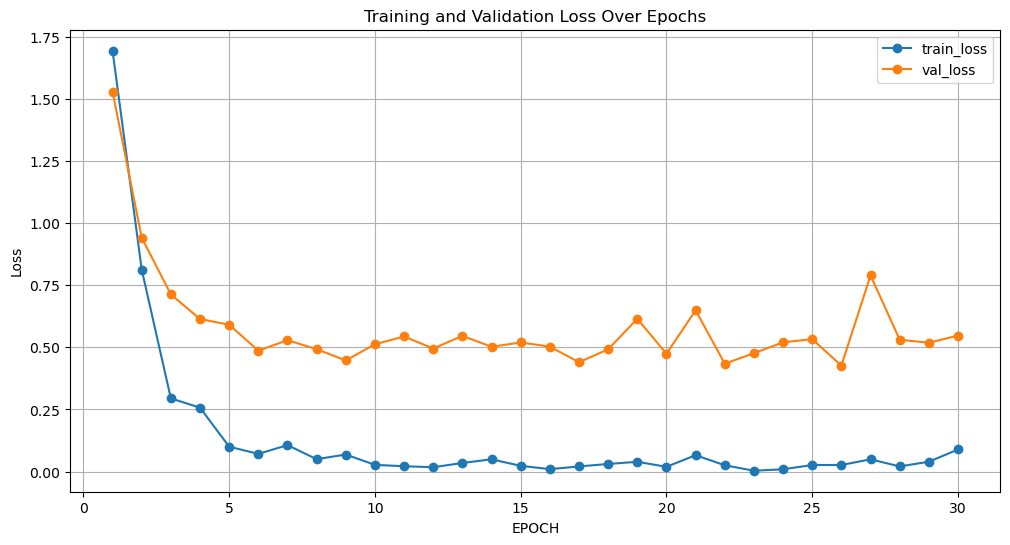

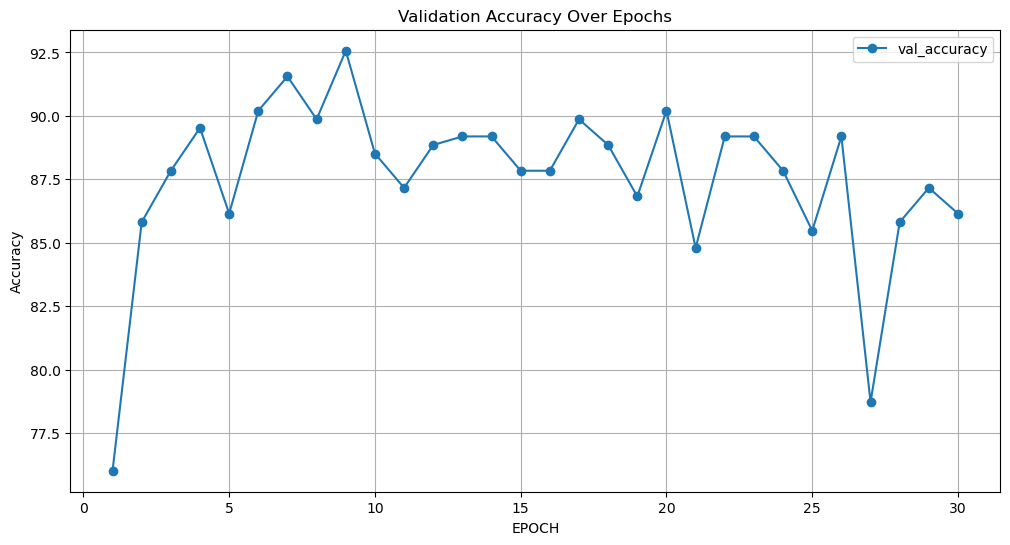

In [ ]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

---------------------------------------------------------------------------
OutOfMemoryError                          Traceback (most recent call last)
Cell In[7], line 8
      5 val_losses = []    # 검증 손실을 저장할 목록
      7 for epoch in range(EPOCH):
----> 8   train_loss = train(model,train_loader,optimizer,epoch)
      9   val_loss,val_accuracy = evaluate(model,val_loader)
     11   # 훈련 및 검증 손실을 목록에 추가

Cell In[5], line 23, in train(model, train_loader, optimizer, epoch)
     19 model.train()
     21 for i,(image,target) in enumerate(train_loader):
     22   # 각 image와 target을 앞서 설정한 DEVICE(GPU 혹은 CPU)에 보내기
---> 23   image,target = image.to(DEVICE),target.to(DEVICE)
     24   # data를 모델에 넣어서 hypothesis 획득
     25   output = model(image)

OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 9.78 GiB total capacity; 1.45 GiB already allocated; 68.00 MiB free; 1.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
